# Demonstration of risky choice tasks

In [1]:
# Point Python to the path where we have installed the bad and darc packages
import sys
sys.path.insert(0, '/Users/btvincent/git-local/darc-experiments-python')

In [2]:
import pandas as pd
import numpy as np

import darc
from darc.risky import models
from darc.designs import BayesianAdaptiveDesignGeneratorDARC
from darc.risky.designs import Griskevicius2011, DuGreenMyerson2002
from dev.darc_parameter_recovery import parameter_recovery_sweep, simulated_experiment_trial_loop
from darc.data_plotting import data_plotter

In [3]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Data generating process
Define everything related to the true simulated observer which generates the data

In [4]:
# ~~~~~~~~~~~~~ UPDATE THIS FOR RISKY CHOICE ~~~~~~~~~~~~~~~~~~~~~

data_generating_model = models.Hyperbolic

def prob_to_odds_against(probabilities):
    '''convert probabilities of getting reward to odds against getting it'''
    odds_against = (1 - probabilities) / probabilities
    return odds_against

def hyperbolic_discount_func(prob, logh):
    h = np.exp(logh)
    odds_against = prob_to_odds_against(prob)
    return np.divide(1, (1 + h * odds_against))

def hyperbolic_posterior_predictive(ax, fitted_model):
    logk = fitted_model.θ['logh'].values  # get posterior samples
    probs = np.linspace(0, 1, 100)
    logh_percentiles = np.percentile(logk,[2.5, 50, 100-2.5])    
    
    y_upper = hyperbolic_discount_func(probs, logh_percentiles[2])
    y_median = hyperbolic_discount_func(probs, logh_percentiles[1])
    y_lower = hyperbolic_discount_func(probs, logh_percentiles[0])

    ax.fill_between(probs, y_lower, y_upper, alpha=0.3, label='95% CI')
    ax.plot(probs, y_median, label='posterior median')
    ax.legend()

# for linear-in-log-odds model
# true_params = [pd.DataFrame.from_dict({'β': [0.2], 's': [1], 'α': [2]}),
#                pd.DataFrame.from_dict({'β': [0.5], 's': [1], 'α': [2]}),
#                pd.DataFrame.from_dict({'β': [0.8], 's': [1], 'α': [2]})]
true_params = [pd.DataFrame.from_dict({'logh': [-0.5], 'α': [2]}),
               pd.DataFrame.from_dict({'logh': [0.], 'α': [2]}),
               pd.DataFrame.from_dict({'logh': [0.5], 'α': [2]}) ]

col_titles = ['example 1', 'example 2', 'example 3']

## Code for visualising the various design approaches


Run simulated experiments

In [13]:
prob_list = [0.05, 0.1, 0.2, 0.25, 0.5, 0.75, 0.8, 0.9, 0.95]

BAD = lambda: BayesianAdaptiveDesignGeneratorDARC(max_trials=20, 
                                                  DA=[0], DB=[0], 
                                                  PA=[1], PB=prob_list,
                                                  RA=list(100*np.linspace(0.05, 0.95, 91)),
                                                  RB=[100])

design_types = [Griskevicius2011, 
                DuGreenMyerson2002,
                BAD]

row_headings = ['Griskevicius\n et al (2011)',
                'Du, Green & Myerson\n(2002)',
                'our approach']

row, col = (0,0)


/Users/btvincent/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys


row, col = (1,0)
row, col = (2,0)
row, col = (0,1)
row, col = (1,1)
row, col = (2,1)
row, col = (0,2)
row, col = (1,2)
row, col = (2,2)


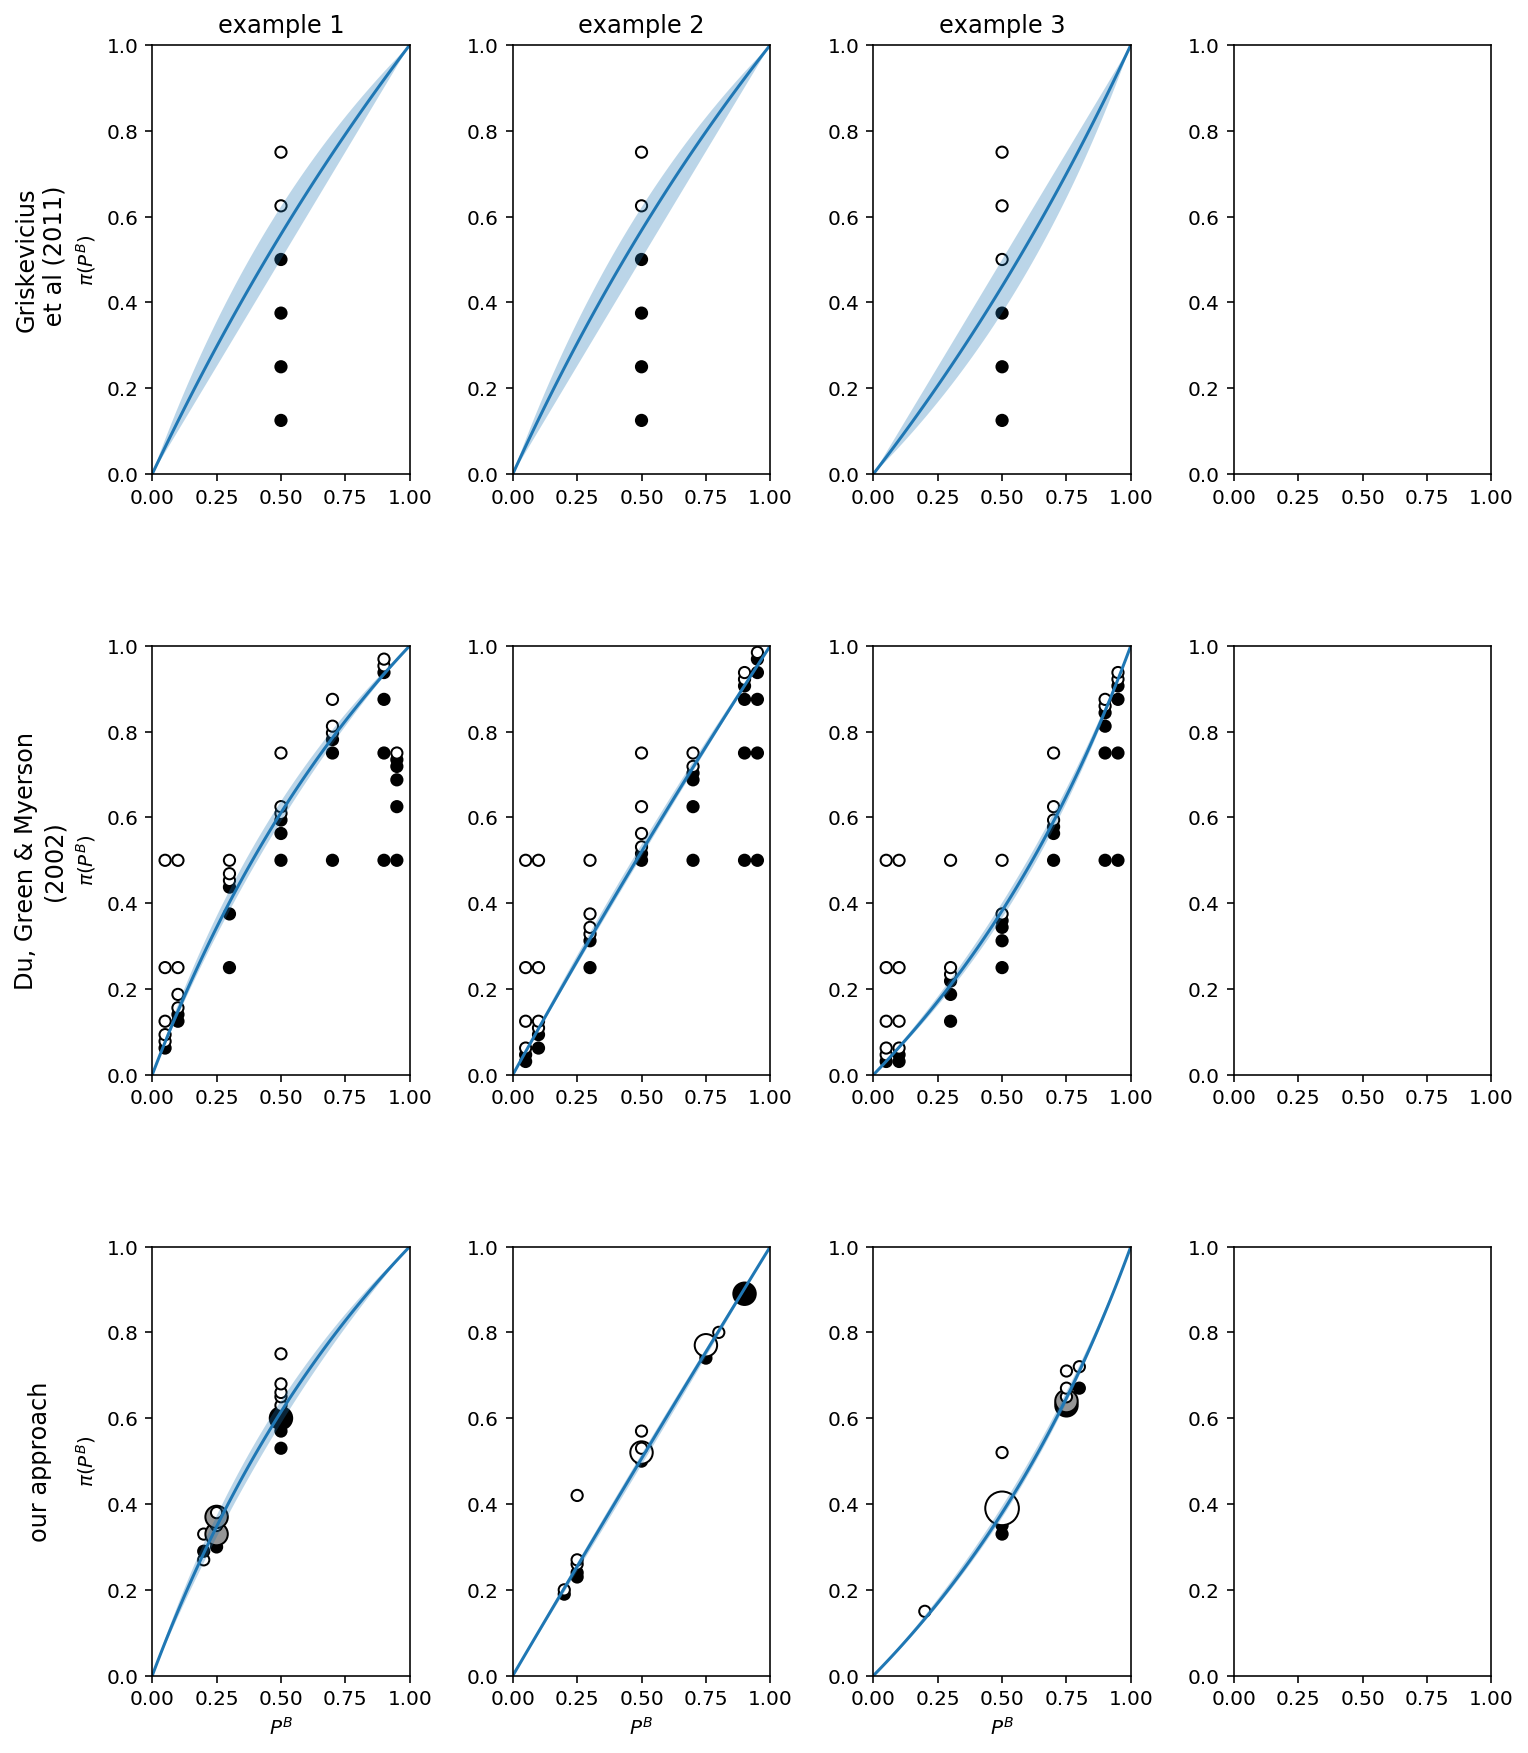

In [14]:
fig, ax = plt.subplots(len(design_types), len(true_params)+1, figsize=(12, 15))

for col, true_p in enumerate(true_params):
    for row, designfunc in enumerate(design_types):
        print(f'row, col = ({row},{col})')
        design_thing = designfunc()
        model = data_generating_model(n_particles=5000)
        model.θ_true = pd.DataFrame.from_dict(true_p)
        fitted_model, _ = simulated_experiment_trial_loop(design_thing,
                                                          model,
                                                          track_this_parameter='logh')
        data_plotter(design_thing.get_df(), ax=ax[row,col])
        hyperbolic_posterior_predictive(ax[row,col], fitted_model)
        
        if col > 0:
            ax[row,col].set_ylabel('')
        
        if row < len(design_types)-1:
            ax[row,col].set_xlabel('')

plt.subplots_adjust(hspace=0.4, wspace=0.4)

[ax[r,c].set_xlim([0, 1]) for r in range(len(design_types)) for c in range(len(true_params))]
[ax[r,c].set_ylim([0, 1]) for r in range(len(design_types)) for c in range(len(true_params))]
[ax[0,c].set_title(title) for c, title in enumerate(col_titles)]
[ax[r,c].get_legend().remove() for r in range(len(design_types)) for c in range(len(true_params))]

pad = 13 # in points
for axis, row_title in zip(ax[:,0], row_headings):
    axis.annotate(row_title, xy=(0, 0.5), xytext=(-axis.yaxis.labelpad - pad, 0),
                  xycoords=axis.yaxis.label, textcoords='offset points',
                  size='large', ha='center', va='center', rotation=90)


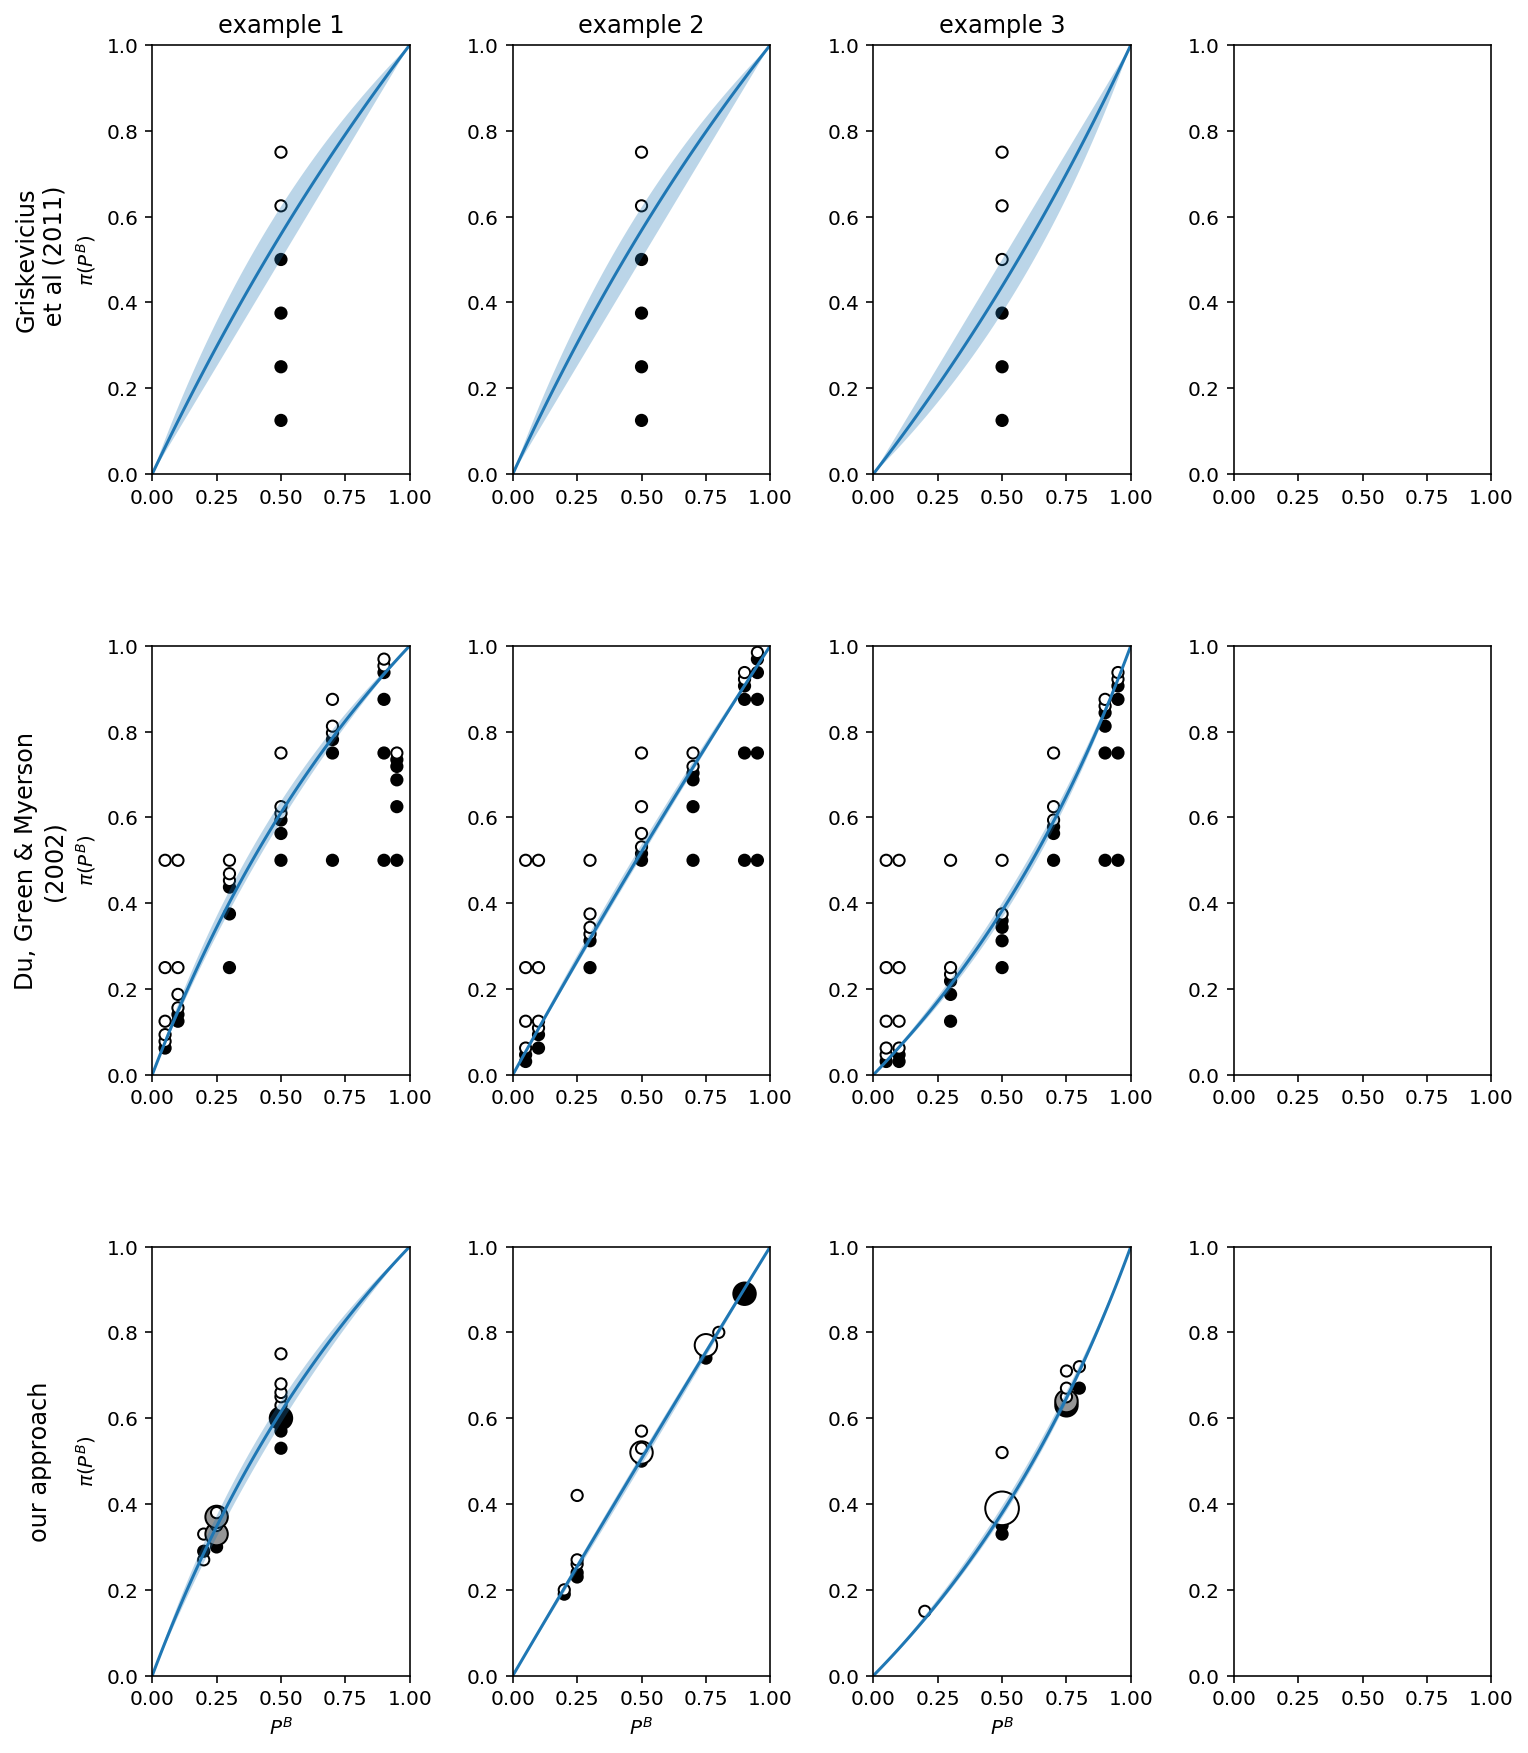

In [15]:
fig

## Code for parameter recovery sweeps
This will fill in the right hand column with parameter recovery sweeps for the corresponding experiment design approaches (rows). This gives a more high level overview of the resulting posterior over a wide range of $\log(k)$ values.

In [ ]:
N = 7  # 70
θsweep = pd.DataFrame.from_dict({'logk': np.linspace(-8, -1, num=N), 
                                 'α': np.ones(N) * 2})

In [ ]:
target_param_name = 'logk'

# Griskevicius -----------------------------------------------------------------
design_thing = Griskevicius2011()
model = data_generating_model(n_particles=5000)
θ_estimated_griskevicius, _ = parameter_recovery_sweep(θsweep, model, design_thing, target_param_name)
n_trials_griskevicius = 7

# Koffarnus & Bickel ----------------------------------------------------------
design_thing = Koffarnus_Bickel()
model = data_generating_model(n_particles=5000)
θ_estimated_koffarnus, _ = parameter_recovery_sweep(θsweep, model, design_thing, target_param_name)
n_trials_koffarnus = 5

# Du, Green & Myerson ----------------------------------------------------------
design_thing = DuGreenMyerson2002()
model = data_generating_model(n_particles=5000)
θ_estimated_DuGreenMyerson, _ = parameter_recovery_sweep(θsweep, model, design_thing, target_param_name)
n_trials_DuGreenMyerson = 6*7

# DARC -----------------------------------------------------------------
max_trials = 20
design_thing = BayesianAdaptiveDesignGeneratorDARC(max_trials=max_trials, 
                                                   PB=list(np.arange(0.01, 0.99, 20)))
model = data_generating_model(n_particles=5000)
θ_estimated_darc, _ = parameter_recovery_sweep(θsweep, model, design_thing, target_param_name)
n_trials_darc = max_trials

In [ ]:
def my_errorbar(ax, θsweep, θ_estimated):
    err_lower = θ_estimated['logk_median'] - θ_estimated['logk_lower95']
    err_upper = θ_estimated['logk_upper95'] - θ_estimated['logk_median']
        
    ax.plot([-8, -1], [-8, -1], c=[0.7, 0.7, 0.7])
    ax.errorbar(x=θsweep['logk'], 
                y=θ_estimated['logk_median'],
                yerr=[err_lower, err_upper],
                fmt='o',
                c='k', 
                ms=3)
    ax.set_xlabel(r'true $\log(k)$')
    ax.set_ylabel(r'estimated $\log(k)$')
    return

col = 3
ax[0,col].set_title('Parameter recovery\nsimulations')
# -----------------------------------------------------
my_errorbar(ax[0,col], θsweep, θ_estimated_kirby)
my_errorbar(ax[1,col], θsweep, θ_estimated_griskevicius)
my_errorbar(ax[2,col], θsweep, θ_estimated_koffarnus)
my_errorbar(ax[3,col], θsweep, θ_estimated_DuGreenMyerson)
my_errorbar(ax[4,col], θsweep, θ_estimated_frye)
my_errorbar(ax[5,col], θsweep, θ_estimated_darc)

# remove x-labels
[ax[i,col].set_xlabel('') for i in range(4)]

# move y axis to the right side
[ax[i,col].yaxis.tick_right() for i in range(5)]

# move y label to the right side
[ax[i,col].yaxis.set_label_position("right") for i in range(5)];

In [ ]:
fig

In [ ]:
fig.savefig('risky_choice_demo.pdf', bbox_inches='tight')